In [139]:
%run Text_Preprocessing.ipynb
%run Validation_and_Testing.ipynb

Documentation:
1. Converted class label to categorical
2. Supplied (original) vectorisers + TF-IDF vectorizer
3. Added preprocessing (punctuation removal, casefolding, stop-words removal (including words to short), lemmatization) steps to the text features
4. Encoded the simple string features ('Authors', 'Publisher', 'Language')
5. Dimensionality reduction with TruncatedSVD
6. Bigrams instead of words
7. Feature selection with SelectKBest
8. Standardization of 'pageNumbers' 
9. Instead of 8: Take the log of the standardized 'pageNumbers' using MinMaxScaler

Yet to try:
* Discretisation of PageNumbers

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy
import re
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load datasets
original_train_df = pd.read_csv(r"book_rating_train.csv", index_col = False, delimiter = ',', header=0)
test_df = pd.read_csv(r"book_rating_test.csv", index_col = False, delimiter = ',', header=0)
print("Training set size:", len(original_train_df))
print("Test set size:", len(test_df))

Training set size: 23063
Test set size: 5766


In [5]:
# Take a holdout as the validation set (our own labelled, test set)
train_df, val_df = train_test_split(original_train_df, train_size=0.8, random_state=30027)

# Preprocessing

In [6]:
STRING_FEATURES = ['Authors', 'Publisher', 'Language']
NUMERICAL_FEATURES = ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber']
TEXT_FEATURES = ['Name', 'Description']
CLASS_LABEL = 'rating_label'

In [7]:
# Check class distributions
class_labels, count = np.unique(original_train_df['rating_label'], return_counts=True)
for pair in zip(class_labels, count):
    print(f"Rating {pair[0]}: {pair[1]} instances")

Rating 3.0: 5864 instances
Rating 4.0: 16208 instances
Rating 5.0: 991 instances


## Preprocess String features: Language, Authors, and Publisher

In [8]:
for feature in STRING_FEATURES:
    print(f"There are {original_train_df[feature].nunique()} unique '{feature}' values.")
    print(f"There are {original_train_df[feature].isna().sum()} missing '{feature}' values.\n")

# Too many missing values in 'Language'. Let's drop it.
train_df = train_df.drop('Language', axis=1)

There are 16301 unique 'Authors' values.
There are 0 missing 'Authors' values.

There are 4247 unique 'Publisher' values.
There are 148 missing 'Publisher' values.

There are 18 unique 'Language' values.
There are 17202 missing 'Language' values.



In [9]:
# For Authors and Publisher, we just do a general text preprocessing here
# The models will have their own strategies to deal with these
for feature in ['Authors', 'Publisher']:
    train_df[feature] = train_df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))

## Preprocess Numerical features: PublishDates and pagesNumber

### Data Visualisation

In [10]:
# Look at NMI of the numerical attributes
train_numerical_df = train_df[NUMERICAL_FEATURES]
train_label = train_df[CLASS_LABEL]

for feature in NUMERICAL_FEATURES:
    print(f"NMI for {feature} =", normalized_mutual_info_score(train_numerical_df[feature], train_label))

NMI for PublishYear = 0.005703215058084223
NMI for PublishMonth = 0.0007283804738261772
NMI for PublishDay = 0.0013567943627829909
NMI for pagesNumber = 0.022262112423956495


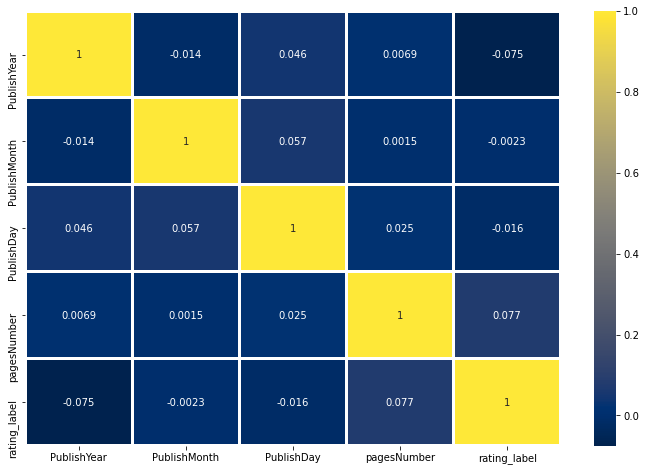

In [11]:
# Look at the correlation matrix of the numerical attributes
cor_matrix = train_df[NUMERICAL_FEATURES + [CLASS_LABEL]].corr()
round(cor_matrix, 2)
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix, cmap='cividis', annot=True, linewidths=2)
plt.show()

In [12]:
def scatter_vs_rating(df, feature):
    plt.scatter(df[feature], df['rating_label'])
    plt.xlabel(feature)
    plt.ylabel('rating')

In [13]:
def hist_plot(df, feature, bins=30):
    plt.hist(df[feature], bins=bins)
    plt.xlabel(feature)
    plt.ylabel('frequency')
    plt.show()

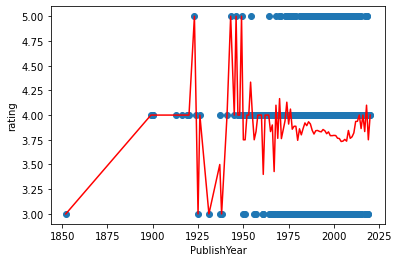

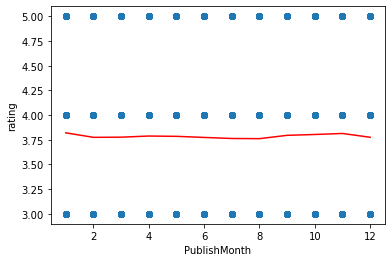

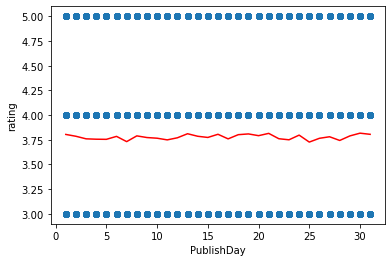

In [14]:
# Scatterplots for Publish year, month, and day vs. Rating
for feature in ['PublishYear', 'PublishMonth', 'PublishDay']: 
    scatter_vs_rating(train_df, feature)
    
    # Look at the average rating for each value
    values, counts = np.unique(sorted(train_df[feature]), return_counts=True)
    avg = [sum(train_df.loc[train_df[feature] == values[i]]['rating_label']) / counts[i] for i in range(len(values))]
    plt.plot(values, avg, color = 'red')
    plt.show()

In [15]:
# Looks like there's little correlation between the Publish time and rating_label
# Let's discard PublishMonth and PublishDay
train_df = train_df.drop(['PublishMonth', 'PublishDay'], axis=1)

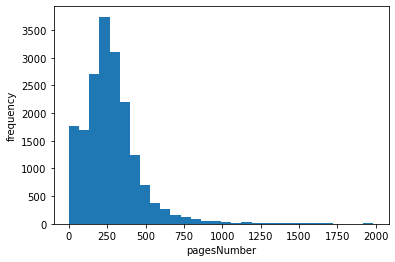

In [16]:
# Histogram for pages number < 2000
hist_plot(train_df.loc[train_df['pagesNumber'] < 2000], 'pagesNumber')

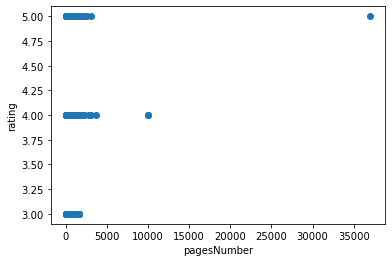

In [17]:
scatter_vs_rating(train_df, 'pagesNumber')
plt.show()

In [18]:
# Try discretizing it
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, feature, discretizer=None, strategy='kmeans', n_bins=7):
    if discretizer is None:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        discretizer.fit(df[[feature]])
        
    transformed_df = df.copy()
    transformed_df[feature] = discretizer.transform(df[[feature]])
    
    return transformed_df, discretizer

In [19]:
DISCRETIZATION_STRATEGIES = ['kmeans', 'quantile', 'uniform']

def tune_discretization(X, y, feature, lower, upper):
    """
    Returns the combination of n (number of bins) and discretisation strategy 
    that gives the highest normalised mutual information between `X` and `y`.
    """
    
    max_nmi = 0
    best_n = 0
    best_strategy = None
    
    for n in range(lower, upper+1):
        for strategy in DISCRETIZATION_STRATEGIES:
            transformed_X, _ = discretize(X, feature, strategy=strategy, n_bins=n)
            nmi = normalized_mutual_info_score(transformed_X[feature], y)
            if nmi > max_nmi:
                max_nmi = nmi
                best_n = n
                best_strategy = strategy
    
    return max_nmi, best_n, best_strategy

In [20]:
max_nmi_pn, best_n_pn, best_strategy_pn = tune_discretization(train_numerical_df, train_label, 'pagesNumber', 2, 20)
print("The number of bins that gives the highest NMI with rating_label is", best_n_pn)
print("The highest NMI is:", max_nmi_pn)
print("The best strategy is:", best_strategy_pn)

The number of bins that gives the highest NMI with rating_label is 7
The highest NMI is: 0.013661409211904464
The best strategy is: kmeans


In [21]:
train_df, discretizer_pn = discretize(train_df, 'pagesNumber', strategy='kmeans', n_bins=7)
np.unique(train_df['pagesNumber'], return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([5572, 8499, 3564,  712,  100,    2,    1]))

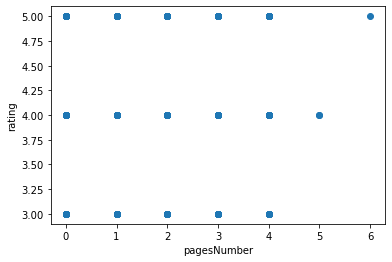

In [22]:
scatter_vs_rating(train_df, 'pagesNumber')

In [23]:
# Try discretizing PublishYear as well 
max_nmi_py, best_n_py, best_strategy_py = tune_discretization(train_numerical_df, train_label, 'PublishYear', 2, 100)
print("The number of bins that gives the highest NMI with rating_label is", best_n_py)
print("The highest NMI is:", max_nmi_py)
print("The best strategy is:", best_strategy_py)

The number of bins that gives the highest NMI with rating_label is 15
The highest NMI is: 0.006807258586597651
The best strategy is: uniform


In [24]:
train_df, discretizer_py = discretize(train_df, 'PublishYear', strategy='uniform', n_bins=15)
np.unique(train_df['PublishYear'], return_counts=True)

(array([ 0.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 array([    1,     3,     3,     5,     5,    17,    50,   189,   868,
         4018, 13008,   283]))

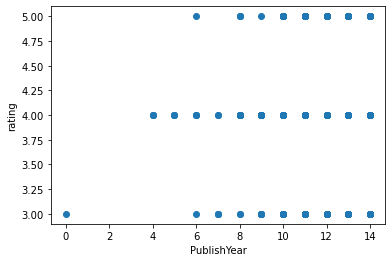

In [25]:
scatter_vs_rating(train_df, 'PublishYear')

## Text Pre-processing

In [26]:
# We use a different delimiter for the name and description bigrams, to prevent duplicate column namaes
train_df_name, vectorizer_name = preprocess_text_feature(train_df, 'Name', ngram=2, delimiter='_')  # can try ngram=1
train_df_desc, vectorizer_desc = preprocess_text_feature(train_df, 'Description', ngram=2)
# print(sorted(vectorizer_name.vocabulary_))
# print(sorted(vectorizer_desc.vocabulary_))

In [27]:
# Bind them together
train_df = pd.concat([train_df.reset_index(drop=True), train_df_name, train_df_desc], axis=1)
train_df = train_df.drop(TEXT_FEATURES, axis=1)  # drop the original columns

## Convert rating_label to categorical class label

In [28]:
# Finally, convert rating_label to categorical class label
train_df[CLASS_LABEL] = train_df[CLASS_LABEL].astype('category')
# move rating_label to the last column
labels = train_df[CLASS_LABEL]
train_df = pd.concat([train_df.drop([CLASS_LABEL], axis=1), labels], axis=1) 

In [29]:
DTYPE = train_df.dtypes.apply(lambda x: x.name).to_dict()  # needed for reading the CSV later
DTYPE['Authors'] = 'string'
DTYPE['Publisher'] = 'string'

In [30]:
# Save the general transformed df
train_df.to_csv("transformed_train_df.csv", index=False)

## Preprocessing: Altogether

In [31]:
def preprocess_test_df(df, discretizer_pn=None, discretizer_py=None, vectorizer_name=None, vectorizer_desc=None):
    # preprocess string features
    for feature in ['Authors', 'Publisher']:
        df[feature] = df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    
    # preprocess pagesNumber and PublishYear
    df, _ = discretize(df, 'pagesNumber', discretizer=discretizer_pn)
    df, _ = discretize(df, 'PublishYear', discretizer=discretizer_py)
    
    # preprocess text features
    df_name, _ = preprocess_text_feature(df, 'Name', vectorizer=vectorizer_name, delimiter='_')
    df_desc, _ = preprocess_text_feature(df, 'Description', vectorizer=vectorizer_desc)
    
    # discard the obsolete original features and some unwanted features
    df = pd.concat([df.reset_index(drop=True), df_name, df_desc], axis=1)
    df = df.drop(['Name', 'Description', 'PublishMonth', 'PublishDay', 'Language'], axis=1)
        
    return df, discretizer_pn, discretizer_py, vectorizer_name, vectorizer_desc

In [32]:
val_df_X = preprocess_test_df(val_df.iloc[:,:-1], discretizer_pn, discretizer_py, vectorizer_name, vectorizer_desc)[0]
val_df_y = val_df[CLASS_LABEL].astype('category')
val_df = pd.concat([val_df_X, val_df_y.reset_index(drop=True)], axis=1)

In [33]:
val_df

,Authors,PublishYear,Publisher,pagesNumber,survival_guide,everything_need,need_know,civil_right,story_behind,every_day,...,three decade,wall street,little girl,comic book,million copy,help student,old testament,orson scott,scott card,rating_label
0,william johnstone,13.0,pinnacle,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,4.0
1,simon sebag montefiore,13.0,knopf,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.0
2,richard holmes,13.0,basic books,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3.0
3,beverly connor,13.0,cumberland house publishing,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.0
4,stephen whitfield,12.0,johns hopkins university press,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.567391,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4608,timothy ross,13.0,wiley,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.0
4609,tami hoag,13.0,orion paperbacks,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.454344,0.0,0.248463,0.0,0.0,0.0,0.0,0.283651,4.0
4610,henry spencer ashbee,12.0,signet classics,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3.0
4611,tracy porter,13.0,llewellyn publications,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.0


In [34]:
val_df.to_csv("transformed_val_df.csv", index=False)

# Model Induction on Training set

In [98]:
X_train = train_df.iloc[:,:-1] # (transformed) attributes
y_train = train_df.iloc[:,-1]  # ground truth labels
# validation set
X_val = val_df.iloc[:,:-1]
y_val = val_df.iloc[:,-1]

In [64]:
X_val

,Authors,PublishYear,Publisher,pagesNumber,survival_guide,everything_need,need_know,civil_right,story_behind,every_day,...,book first,three decade,wall street,little girl,comic book,million copy,help student,old testament,orson scott,scott card
0,william johnstone,13.0,pinnacle,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000
1,simon sebag montefiore,13.0,knopf,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,richard holmes,13.0,basic books,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,beverly connor,13.0,cumberland house publishing,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,stephen whitfield,12.0,johns hopkins university press,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.567391,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4608,timothy ross,13.0,wiley,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4609,tami hoag,13.0,orion paperbacks,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.454344,0.0,0.248463,0.0,0.0,0.0,0.0,0.283651
4610,henry spencer ashbee,12.0,signet classics,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4611,tracy porter,13.0,llewellyn publications,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


## Naive Bayes

In [253]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.linear_model import LogisticRegression

In [254]:
GAUSSIAN_FEATURES = ['PublishYear', 'pagesNumber']
CATEGORICAL_FEATURES = ['Authors', 'Publisher']
MULTINOMIAL_FEATURES = list(X_train.columns)[4:]

In [270]:
X_train_gaussian = X_train[GAUSSIAN_FEATURES]
X_val_gaussian = X_val[GAUSSIAN_FEATURES]
X_train_categorical = X_train[CATEGORICAL_FEATURES]
X_val_categorical = X_val[CATEGORICAL_FEATURES]
X_train_multinomial = X_train[MULTINOMIAL_FEATURES]
X_val_multinomial = X_val[MULTINOMIAL_FEATURES]

In [271]:
from sklearn.preprocessing import OrdinalEncoder

# CategoricalNB works with numbers - but treats them as categorical instead of ordinal features
enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
enc.fit(X_train[CATEGORICAL_FEATURES])
X_train_categorical = pd.DataFrame(enc.transform(X_train[CATEGORICAL_FEATURES]))
X_val_categorical = pd.DataFrame(enc.transform(X_val[CATEGORICAL_FEATURES]))
for feature in X_val_categorical.columns:
    X_val_categorical[feature] = X_val_categorical[feature].replace(-1, X_val_categorical[feature].nunique())

### Gaussian NB for PublishYear and pagesNumber

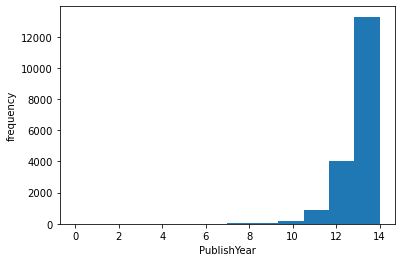

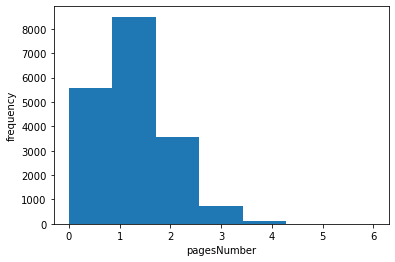

In [263]:
# check distribution of PublishYear and pagesNumber
for feature in GAUSSIAN_FEATURES:
    hist_plot(X_train, feature, bins=X_train[feature].nunique())

Evaluate on training set:

GaussianNB prediction took 0.2952120304107666 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.822023           0.125000       0.698808
1                 0.0           0.820972           0.000000       0.695558
2                 0.0           0.823529           0.130435       0.700975
3                 0.0           0.823077           0.160000       0.699892
4                 0.0           0.821953           0.000000       0.697725
5                 0.0           0.823229           0.046512       0.699892
6                 0.0           0.823529           0.130435       0.700975
7                 0.0           0.825336           0.212766       0.704225
8                 0.0           0.821497           0.085106       0.697725
9                 0.0           0.825559           0.177778       0.704225
10                0.0           0.825782           0.097561       0.703905
11                0

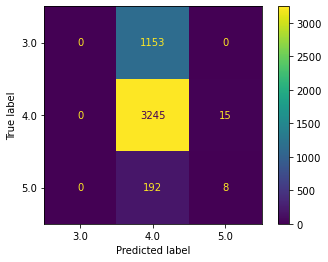

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.35      0.04      0.07       200

    accuracy                           0.71      4613
   macro avg       0.35      0.35      0.30      4613
weighted avg       0.51      0.71      0.59      4613



In [264]:
gnb = GaussianNB()
gaussian_pred = validate_and_test(gnb, X_train_gaussian, y_train, X_val_gaussian, y_val)

### Categorical NB for Authors and Publisher

In [274]:
# Tuning for alpha smoothing
cnb = CategoricalNB(min_categories = [X_train_categorical[feature].nunique()+1 for feature in X_train_categorical.columns])
param_grid = {'alpha': [i/10 for i in range(1, 15, 1)]}
tune_hyperparameter(cnb, param_grid, X_train_categorical, y_train.astype(int))

# larger alpha -> overestimate the likelihood
# could be because there is more samples with label4 ratings, and the missing values are randomly 
# distributed across the dataset, hence more samples with label4 rating with missing values
# -> likelihood of P(x|c=4) overestimated -> more samples predicted to have label=4

Fitting 20 folds for each of 14 candidates, totalling 280 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .....................................

[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ...................

[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ...................

,params,mean_test_3_f1-score,rank_test_3_f1-score,mean_test_4_f1-score,rank_test_4_f1-score,mean_test_5_f1-score,rank_test_5_f1-score,mean_test_accuracy,rank_test_accuracy
0,{'alpha': 0.1},0.451433,1,0.724275,14,0.241945,6,0.612951,14
1,{'alpha': 0.2},0.424490,2,0.751430,13,0.248925,4,0.636420,13
2,{'alpha': 0.3},0.412761,3,0.768410,12,0.310519,1,0.661406,12
3,{'alpha': 0.4},0.405926,4,0.775756,11,0.288403,2,0.667964,11
4,{'alpha': 0.5},0.396606,5,0.782229,10,0.260520,3,0.673710,10
5,{'alpha': 0.6},0.386439,6,0.784805,9,0.246931,5,0.675065,9
6,{'alpha': 0.7},0.378773,7,0.787925,8,0.214164,7,0.677233,6
7,{'alpha': 0.8},0.373553,8,0.789128,7,0.196507,8,0.677721,5
8,{'alpha': 0.9},0.364608,9,0.789764,6,0.144934,9,0.676529,7
9,{'alpha': 1.0},0.358524,10,0.789772,5,0.142954,10,0.675824,8


Evaluate on training set:

CategoricalNB prediction took 0.3348560333251953 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.318627           0.789360           0.127660       0.668472
1            0.357647           0.782293           0.093023       0.668472
2            0.377171           0.811159           0.177778       0.700975
3            0.386047           0.793003           0.090909       0.681473
4            0.372960           0.787172           0.133333       0.674973
5            0.320802           0.792291           0.217391       0.676056
6            0.392344           0.810382           0.048780       0.698808
7            0.345324           0.789017           0.177778       0.673889
8            0.418605           0.805252           0.133333       0.698808
9            0.364045           0.781457           0.095238       0.665222
10           0.387850           0.795918           0.136364       0.685466
11           0.3

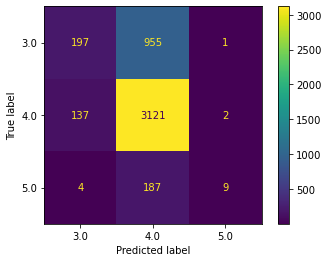

              precision    recall  f1-score   support

         3.0       0.58      0.17      0.26      1153
         4.0       0.73      0.96      0.83      3260
         5.0       0.75      0.04      0.08       200

    accuracy                           0.72      4613
   macro avg       0.69      0.39      0.39      4613
weighted avg       0.70      0.72      0.66      4613



In [276]:
cnb = CategoricalNB(alpha = 1, min_categories = [X_train_categorical[feature].nunique()+1 for feature in X_train_categorical.columns])
categorical_pred = validate_and_test(cnb, X_train_categorical, y_train, X_val_categorical, y_val)


### Multinomial NB for Name and Description

Evaluate on training set:

MultinomialNB prediction took 1.4693188667297363 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.077821           0.821244           0.044444       0.698808
1            0.079681           0.826031           0.000000       0.705309
2            0.062745           0.818418           0.081633       0.694475
3            0.121673           0.824447           0.088889       0.706392
4            0.080000           0.826787           0.000000       0.706392
5            0.048193           0.822165           0.088889       0.699892
6            0.077821           0.824822           0.095238       0.704225
7            0.069767           0.821012           0.130435       0.698808
8            0.101167           0.824903           0.042553       0.704225
9            0.071146           0.824289           0.088889       0.703142
10           0.055336           0.821705           0.139535       0.700651
11           0.0

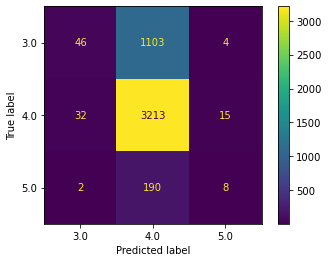

              precision    recall  f1-score   support

         3.0       0.57      0.04      0.07      1153
         4.0       0.71      0.99      0.83      3260
         5.0       0.30      0.04      0.07       200

    accuracy                           0.71      4613
   macro avg       0.53      0.36      0.32      4613
weighted avg       0.66      0.71      0.61      4613



In [277]:
# better than complementNB and gaussianNB
mnb = MultinomialNB()
multinomial_pred = validate_and_test(mnb, X_train_multinomial, y_train, X_val_multinomial, y_val)

### Categorical NB for final prediction

In [278]:
# use a categorical nb to predict the final rating
# training dataframe
gnb.fit(X_train_gaussian, y_train)
gaussian_pred_training = gnb.predict(X_train_gaussian)
cnb.fit(X_train_categorical, y_train)
categorical_pred_training = cnb.predict(X_train_categorical)
mnb.fit(X_train_multinomial, y_train)
multinomial_pred_training = mnb.predict(X_train_multinomial)

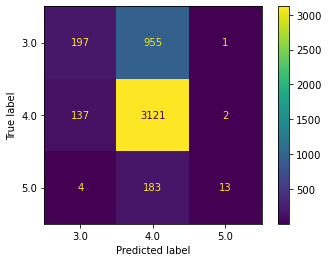

              precision    recall  f1-score   support

         3.0       0.58      0.17      0.26      1153
         4.0       0.73      0.96      0.83      3260
         5.0       0.81      0.07      0.12       200

    accuracy                           0.72      4613
   macro avg       0.71      0.40      0.40      4613
weighted avg       0.70      0.72      0.66      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [279]:
X_predictions_training = pd.DataFrame({'GaussianNB_Year_Pages' : gaussian_pred_training,
                                'CategoricalNB_Author_Publisher' : categorical_pred_training,
                                'MultinomialNB_Name_Desc' : multinomial_pred_training})

# validation dataframe
X_predictions_val = pd.DataFrame({'GaussianNB_Year_Pages' : gaussian_pred,
                                'CategoricalNB_Author_Publisher' : categorical_pred,
                                'MultinomialNB_Name_Desc' : multinomial_pred})

final_nb = CategoricalNB()
final_nb.fit(X_predictions_training, y_train)
final_nb.predict(X_predictions_training)
evaluate(final_nb, X_predictions_val, y_val, print_confusion_matrix=True, print_classification_report=True)

### Predict_proba + Logistic Regression for final prediction

In [280]:
gnb.fit(X_train_gaussian, y_train)
gaussian_pred_training = gnb.predict_proba(X_train_gaussian)
cnb.fit(X_train_categorical, y_train)
categorical_pred_training = cnb.predict_proba(X_train_categorical)
mnb.fit(X_train_multinomial, y_train)
multinomial_pred_training = mnb.predict_proba(X_train_multinomial)
X_meta_training = np.concatenate([gaussian_pred_training, categorical_pred_training, multinomial_pred_training], axis=1)

In [281]:
gaussian_pred_val = gnb.predict_proba(X_val_gaussian)
categorical_pred_val = cnb.predict_proba(X_val_categorical)
multinomial_pred_val = mnb.predict_proba(X_val_multinomial)
X_meta_val = np.concatenate([gaussian_pred_val, categorical_pred_val, multinomial_pred_val], axis=1)

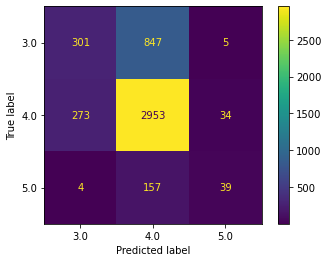

              precision    recall  f1-score   support

         3.0       0.52      0.26      0.35      1153
         4.0       0.75      0.91      0.82      3260
         5.0       0.50      0.20      0.28       200

    accuracy                           0.71      4613
   macro avg       0.59      0.45      0.48      4613
weighted avg       0.68      0.71      0.68      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [282]:
from sklearn.linear_model import LogisticRegression
meta_classifier_lr = LogisticRegression()
meta_classifier_lr.fit(X_meta, y_train)
evaluate(meta_classifier_lr, X_meta_val, y_val, print_confusion_matrix=True, print_classification_report=True)

### Generate Model

In [57]:
FEATURE_SETS = [GAUSSIAN_FEATURES, CATEGORICAL_FEATURES, MULTINOMIAL_FEATURES]

In [330]:
from sklearn.metrics import accuracy_score
from sklearn.base import ClassifierMixin, BaseEstimator

FEATURE_SETS = [GAUSSIAN_FEATURES, CATEGORICAL_FEATURES, MULTINOMIAL_FEATURES]

class StackingNB(ClassifierMixin, BaseEstimator):

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier
        self.feature_sets = FEATURE_SETS
        #self.encoder = encoder
        
        self.encoder = None

    def fit(self, X, y):
        X = X.copy()
        
        self.encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
        self.encoder.fit(X[CATEGORICAL_FEATURES])
        
        X[CATEGORICAL_FEATURES] = self.encoder.transform(X[CATEGORICAL_FEATURES])
        base_preds = []
        for clf, feature_set in zip(self.classifiers, self.feature_sets):
            clf.fit(X[feature_set], y)  # classifier uses a subset of features
        #print(self.classifiers[1].category_count_)
        #print(self.classifiers[1].feature_log_prob_)
        
        X_meta = self._predict_base(X) # output of the base classifiers = input for meta-classifier
        self.metaclassifier.fit(X_meta, y) #output of the base classifiers is the input for the meta classifier
        return self
    
    def _predict_base(self, X):
        y_hats = []
        for clf, feature_set in zip(self.classifiers, self.feature_sets):
            y_hat = clf.predict(X[feature_set])
            y_hats.append(y_hat)
        
        y_hats = pd.DataFrame({'GaussianNB_pred' : y_hats[0],
                               'CategoricalNB_pred' : y_hats[1],
                               'MultinomialNB_pred' : y_hats[2]})
        assert y_hats.shape[0] == X.shape[0] # check that the number of rows yhats matches the number of rows in the input data X
        return y_hats
    
    def predict(self, X):
        X = X.copy()
        X[CATEGORICAL_FEATURES] = self.encoder.transform(X[CATEGORICAL_FEATURES])
        
        for i in [0,1]: 
            X[CATEGORICAL_FEATURES[i]] = X[CATEGORICAL_FEATURES[i]].replace(-1, self.encoder.categories_[i].size)
        #print(X[CATEGORICAL_FEATURES])
            
        X_meta = self._predict_base(X)
        y_hat = self.metaclassifier.predict(X_meta)
        return y_hat
    
    def predict_proba(self, X): 
        X = X.copy()
        X[CATEGORICAL_FEATURES] = self.encoder.transform(X[CATEGORICAL_FEATURES])
        X_meta = self._predict_base(X)
        return self.metaclassifier.predict_proba(X_meta)
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return accuracy_score(y, y_hat)

In [331]:
base_classifiers = [GaussianNB(),
                    CategoricalNB(alpha = 1, min_categories = [X_train[feature].nunique()+1 for feature in CATEGORICAL_FEATURES]),
                    MultinomialNB()]


# to see the different in output when min_categories is different: 
#enc = OrdinalEncoder()
#enc.fit(pd.concat([X_train[CATEGORICAL_FEATURES], X_val[CATEGORICAL_FEATURES]]))
#base_classifiers = [GaussianNB(),
#                    CategoricalNB(alpha = 1, min_categories = [enc.categories_[i].size for i in [0,1]]),
#                    MultinomialNB()]


In [332]:
X_train['Authors'].nunique()

13546

Evaluate on training set:

StackingNB prediction took 9.178498983383179 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.318627           0.789360           0.127660       0.668472
1            0.357647           0.782293           0.093023       0.668472
2            0.377171           0.811159           0.177778       0.700975
3            0.386047           0.794161           0.173913       0.683640
4            0.372960           0.787172           0.133333       0.674973
5            0.320802           0.792291           0.217391       0.676056
6            0.392344           0.811552           0.139535       0.700975
7            0.345324           0.790159           0.255319       0.676056
8            0.418605           0.805839           0.173913       0.699892
9            0.364045           0.782609           0.181818       0.667389
10           0.387850           0.796499           0.177778       0.686551
11           0.35764

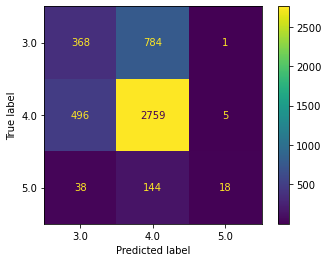

              precision    recall  f1-score   support

         3.0       0.41      0.32      0.36      1153
         4.0       0.75      0.85      0.79      3260
         5.0       0.75      0.09      0.16       200

    accuracy                           0.68      4613
   macro avg       0.64      0.42      0.44      4613
weighted avg       0.66      0.68      0.66      4613



In [333]:
# meta_classifier = categoricalNB
meta_classifier = CategoricalNB()
snb = StackingNB(base_classifiers, meta_classifier)
snb.fit(X_train, y_train)
final_pred = validate_and_test(snb, X_train, y_train, X_val, y_val)

Evaluate on training set:

StackingNB prediction took 15.361557960510254 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.320197           0.791098           0.127660       0.670639
1            0.357647           0.782293           0.093023       0.668472
2            0.377171           0.811159           0.177778       0.700975
3            0.384075           0.794182           0.090909       0.682557
4            0.372960           0.787172           0.133333       0.674973
5            0.320802           0.792291           0.217391       0.676056
6            0.392344           0.811552           0.139535       0.700975
7            0.345324           0.790159           0.255319       0.676056
8            0.418605           0.805839           0.173913       0.699892
9            0.364045           0.781457           0.095238       0.665222
10           0.387850           0.795918           0.136364       0.685466
11           0.3576

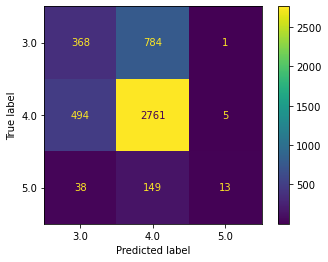

              precision    recall  f1-score   support

         3.0       0.41      0.32      0.36      1153
         4.0       0.75      0.85      0.79      3260
         5.0       0.68      0.07      0.12       200

    accuracy                           0.68      4613
   macro avg       0.61      0.41      0.42      4613
weighted avg       0.66      0.68      0.66      4613



In [334]:
# meta classifier = LogisticRegression
meta_classifier_lr = LogisticRegression()
snb_lr = StackingNB(base_classifiers, meta_classifier_lr)
snb_lr.fit(X_train, y_train)
final_pred = validate_and_test(snb_lr, X_train, y_train, X_val, y_val)
# yields similar result

## SVM

### Linear

In [ ]:
from sklearn import svm

In [ ]:
linearSVM = svm.LinearSVC(random_state=30027, C=10) # set C?
linearSVM.fit(X_train, y_train)
validate_and_test(linearSVM, X_train, y_train, X_val, y_val)

In [ ]:
# Linear SVM using Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# learning_rate='optimal' predicts most 4s as 3s
# validation accuracy stops increasing for eta0 < 0.0000001
svm_sgd = SGDClassifier(learning_rate='adaptive', eta0 = 0.0000001)  # default: loss='hinge' -> gives a linear SVM
validate_and_test(svm_sgd, X_train, y_train, X_val, y_val)

### Kernel SVM

In [ ]:
# tune hyperparameter C
RBF_svm = svm.SVC(kernel='rbf', gamma=0.9)
param_grid = {'C': range(1, 10)}
grid_search_result = tune_hyperparameter(RBF_svm, param_grid, X_train, y_train)

In [ ]:
grid_search_result

In [ ]:
# Try kernel SVM
RBF_svm = svm.SVC(kernel='rbf', gamma=0.9, C=10)
validate_and_test(RBF_svm, X_train, y_train, X_val, y_val)

## kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# tune hyperparameters p and K
knn = KNeighborsClassifier(weights = 'distance')
param_grid = {'p': [1,2], 'n_neighbors': range(1,11)}
grid_search_result = tune_hyperparameter(knn, param_grid, X_train, y_train)

In [ ]:
grid_search_result
# p=2 (euclidean distance) is generally better
# larger k models prefers label 4.0 and hence results in higher accuracy due to data imbalance

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
validate_and_test(knn, X_train, y_train, X_val, y_val)

## Decision Tree

In [123]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# tune hyperparameter max_depth
dtc = DecisionTreeClassifier(random_state = 30027)
param_grid = {'max_depth': range(2,21)}
grid_search_result = tune_hyperparameter(dtc, param_grid, X_train, y_train)

In [ ]:
grid_search_result
# smaller depth converge towards 0R and prefers 4.0 label

In [ ]:
dtc = DecisionTreeClassifier(max_depth=20, random_state = 30027)
validate_and_test(dtc, X_train, y_train, X_val, y_val)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# using full feature set
logr = LogisticRegression()
validate_and_test(logr, X_train, y_train, X_val, y_val)

In [ ]:
# Feature selection
selector = SelectKBest(k=100)
selector.fit(X_train, y_train)
X_train_reduced = selector.transform(X_train)
X_val_reduced = selector.transform(X_val)
print(X_train_reduced.shape)
print(X_val_reduced.shape)

In [ ]:
# using reduced feature set
validate_and_test(logr, X_train_reduced, y_train, X_val_reduced, y_val)



In [ ]:
# Logistic regression using Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# learning_rate='optimal' -> validation accuracy = 0.535
# probabilistic -> different accuracy each time
# eta0=0.0000001 -> low variance, capped at 0.698
# eta0=0.001 -> high variance, occasionally reached 0.7
logr_sgd = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.0000001)
validate_and_test(logr_sgd, X_train, y_train, X_val, y_val)

## Boosting

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def one_hot_encode(df, feature, ohe=None):
    if ohe is None:
        ohe = OneHotEncoder(handle_unknown='ignore')
        ohe.fit(df[[feature]])
    
    transformed_col = ohe.transform(df[[feature]])  # a sparse matrix
    transformed_df = pd.DataFrame.sparse.from_spmatrix(transformed_col).set_axis(ohe.categories_[0], axis=1, inplace=False)
    
    return transformed_df, ohe

In [ ]:
transformed_author, ohe_author = one_hot_encode(X_train, 'Authors')
transformed_publisher, ohe_publisher = one_hot_encode(X_train, 'Publisher')
transformed_X_train = pd.concat([transformed_author, transformed_publisher, X_train.reset_index(drop=True)], axis=1)
transformed_X_train = transformed_X_train.drop(['Authors', 'Publisher'], axis=1)
transformed_X_train

In [ ]:
# Do the same for the validation set
transformed_author, _ = one_hot_encode(X_val, 'Authors', ohe=ohe_author)
transformed_publisher, _ = one_hot_encode(X_val, 'Publisher', ohe=ohe_publisher)
transformed_X_val = pd.concat([transformed_author, transformed_publisher, X_val.reset_index(drop=True)], axis=1)
transformed_X_val = transformed_X_val.drop(['Authors', 'Publisher'], axis=1)
transformed_X_val

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adab = AdaBoostClassifier(n_estimators=100, random_state=30027)
validate_and_test(adab, transformed_X_train, y_train, transformed_X_val, y_val)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=30027)
validate_and_test(rf, X_train, y_train, X_val, y_val)

## Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier

classifiers = [('linearSVM', linearSVM), ('svm_sgd', svm_sgd), ('RBF_svm', RBF_svm), ('knn', knn), ('dtc', dtc)]#, ('logr', logr)]
sc = StackingClassifier(classifiers, verbose = 1)
validate_and_test(sc, X_train, y_train, X_val, y_val)

In [ ]:
evaluate(stacking_clf, X_val, y_val, print_confusion_matrix=True, print_classification_report=True)

## Baseline - 0R & 1R

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.dummy import DummyClassifier

In [ ]:
# build and test 0R and 1R model
zero_r = DummyClassifier(strategy='most_frequent')
one_r = DecisionTreeClassifier(max_depth=1)
baselines = [zero_r, one_r]

for baseline in baselines: 
    validate_and_test(baseline, X_train, y_train, X_val, y_val, print_full_cv_results=False)
    print("\n*****************************\n")